In [6]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import pandas as pd

In [2]:
from datasets import load_dataset

In [4]:
dataset = load_dataset("aeslc")

Using custom data configuration default
Found cached dataset aeslc (C:/Users/mchou/.cache/huggingface/datasets/aeslc/default/1.0.0/eb8e30234cf984a58ebe9f205674597ac1db2ec91e7321cd7f36864f7e3671b8)


  0%|          | 0/3 [00:00<?, ?it/s]

# Import the dataset (Dataset is taken from kaggle)

In [12]:
source_train_df = pd.DataFrame(dataset["train"])
source_train_df.to_csv("train.csv",index=False)

In [8]:
validation_train_df = pd.DataFrame(dataset["validation"])

In [9]:
test_train_df = pd.DataFrame(dataset["test"])

In [51]:
data1_df = pd.read_csv("data\cnn\data1.csv")

In [52]:
data1_df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
0.0          393    389  You have received this message because someone...   
1.0         1509   1506  You have received this message because someone...   

               
         freq  
Category       
0.0         2  
1.0         4

In [53]:
data1_df['Category'].value_counts()

1.0    1509
0.0     393
Name: Category, dtype: int64

In [54]:
393/1509

0.26043737574552683

# 24% not pii, 76% pii: This indicates class imbalance

In [55]:

data1_df_pii = data1_df[data1_df['Category']==1]
data1_df_pii.shape

(1509, 2)

In [56]:
data1_df_no_pii = data1_df[data1_df['Category']==0]
data1_df_no_pii.shape

(393, 2)

In [57]:
data1_pii_downsampled = data1_df_pii.sample(data1_df_no_pii.shape[0])
data1_pii_downsampled.shape

(393, 2)

In [58]:
data1_balanced = pd.concat([data1_pii_downsampled, data1_df_no_pii])
data1_balanced.shape

(786, 2)

In [59]:
data1_balanced['Category'].value_counts()

0.0    393
1.0    393
Name: Category, dtype: int64

# Split it into training and test data set

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data1_balanced['Message'],data1_balanced['Category'], stratify=data1_balanced['Category'])

In [61]:
X_train.head(4)

591                                          209-810-7484
44      I am changing the way the curve is generated s...
1674    ttached are the revenues and the volumes per c...
1663    As part of the HPL transition, we are reviewin...
Name: Message, dtype: object

# Now lets import BERT model and get embeding vectors for few sample statements

In [62]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [63]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435169 , -0.5132727 , -0.8884572 , ..., -0.7474887 ,
        -0.75314736,  0.91964495],
       [-0.87208354, -0.50543964, -0.9444669 , ..., -0.8584749 ,
        -0.7174534 ,  0.88082975]], dtype=float32)>

# Get embeding vectors for few sample words. Compare them using cosine similarity

In [64]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [65]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

### Values near to 1 means they are similar. 0 means they are very different. Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits

In [66]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703875]], dtype=float32)

Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes

In [67]:
cosine_similarity([e[3]],[e[4]])

array([[0.9872036]], dtype=float32)

 Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above

# Build Model


There are two types of models you can build in tensorflow.

(1) Sequential (2) Functional

In [68]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [69]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [70]:
len(X_train)

589

In [71]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

Train the model

In [72]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
19/19 [==============================] - 74s 4s/step - loss: 0.5814 - accuracy: 0.7097 - precision: 0.7067 - recall: 0.7186
Epoch 2/10
19/19 [==============================] - 65s 3s/step - loss: 0.4640 - accuracy: 0.8455 - precision: 0.8355 - recall: 0.8610
Epoch 3/10
19/19 [==============================] - 66s 3s/step - loss: 0.3990 - accuracy: 0.8829 - precision: 0.8870 - recall: 0.8780
Epoch 4/10
19/19 [==============================] - 64s 3s/step - loss: 0.3476 - accuracy: 0.9134 - precision: 0.8961 - recall: 0.9356
Epoch 5/10
19/19 [==============================] - 64s 3s/step - loss: 0.3174 - accuracy: 0.9219 - precision: 0.9136 - recall: 0.9322
Epoch 6/10
19/19 [==============================] - 64s 3s/step - loss: 0.2961 - accuracy: 0.9338 - precision: 0.9354 - recall: 0.9322
Epoch 7/10
19/19 [==============================] - 63s 3s/step - loss: 0.2800 - accuracy: 0.9287 - precision: 0.9175 - recall: 0.9424
Epoch 8/10
19/19 [==============================] - 64s

In [73]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 24s 3s/step - loss: 0.1987 - accuracy: 0.9645 - precision: 0.9789 - recall: 0.9490


[0.1987488865852356,
 0.9644669890403748,
 0.9789473414421082,
 0.9489796161651611]

In [74]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

7/7 [==============================] - 23s 3s/step


In [75]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1])

In [76]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[97,  2],
       [ 5, 93]], dtype=int64)

Text(33.0, 0.5, 'Truth')

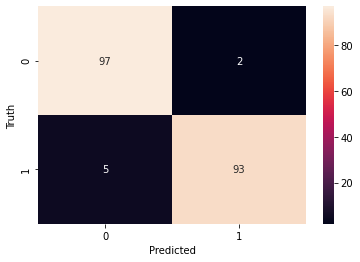

In [77]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [78]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97        99
         1.0       0.98      0.95      0.96        98

    accuracy                           0.96       197
   macro avg       0.96      0.96      0.96       197
weighted avg       0.96      0.96      0.96       197

